# Age Estimation CNN (VGG16, VGG-Face Transfer Learning)

## Import Dependencies

In [1]:
import os
import numpy as np
from numpy import array
from numpy import argmax
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import glob
import keras
import time
from keras import backend as K
from keras.layers.core import Dense
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import CSVLogger, EarlyStopping, TensorBoard, ModelCheckpoint 
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

%matplotlib inline



Using TensorFlow backend.


In [2]:
#Ensure we are using GPU for training
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13498885670856726070
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5484933120
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17575573850553417502
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


## Preprocessing

In [3]:
#Read csv of labels
image_labels = pd.read_csv('train_target.csv')

## Plotting Helper Function

In [4]:
#Define Helper Function to Plot Image
def plotImage(image):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[0].grid()
    axarr[0].set_title('Image')

### Read images and prepare dataset

In [5]:
#Create X_train and Y_train collection
X_train = []
Y_train = []

#Iterate through labels
for index, row in image_labels.iterrows():
    #Read the image to a numpy array and resize to input size of VGG-16
    image = imread('train/' + row[0], mode='RGB')
    image = imresize(image, (224,224,3))
    
    #Append data and labels to collections
    X_train.append(np.array(image))
    Y_train.append(row[1])

C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


In [6]:
#Convert to numpy array
X_train = np.array(X_train)

In [7]:
#Convert labels to one_hot representation, save Y_train_regression before manipulating (regression does not need one-hot representation)
Y_train_regression = Y_train
Y_train = to_categorical(Y_train)

In [8]:
#Split data into training and testing
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_train, Y_train_regression, test_size=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=3)


In [9]:
#Determine number of classes to classify
num_classes = np.size(Y_train, 1)

49


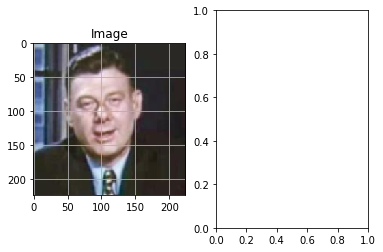

In [10]:
#Make sure our images and labels are in order.
num = 1043
plotImage(X_train[num])
print(argmax(y_train[num]))

## VGG-Face Model (Resnet50) Attempt 1

In [12]:
image_input = Input(shape=(224,224,3))
from keras_vggface.vggface import VGGFace

#Create VGG Face Model
vgg_face_model = VGGFace(input_tensor=image_input, model = 'resnet50', include_top = False, weights='vggface', input_shape=((224,224,3)))

#Print layers of the model
vgg_face_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [13]:
#Freeze all layers except for the last convolution block (We want to fine-tune the last block as well as the classifier)
for layer in vgg_face_model.layers[:-31]:
    layer.trainable = False

In [14]:
#Add fully connected layers to the end of the last convolution block
LL = vgg_face_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(LL)
x = Dense(5000,name = 'fc8')(x)
x = Dropout(0.5)(x)
x = Dense(4096,name = 'fc9')(x)
out = Dense(num_classes, activation='softmax',name='classifier')(x)
custom_vgg_face_model = Model(vgg_face_model.input, out)

In [15]:
#See the architecture of our new model
custom_vgg_face_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [16]:
#Specify SGD as the optimizers and define the loss function.  Compile the model.
sgd = SGD(lr=1e-4, decay=1e-3, momentum=0.9)
custom_vgg_face_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#calculate the total time taken to train the model
t=time.time()

#Define the callbacks, allow early stopping to prevent overfitting.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
callback_list = [early_stop]

#Train the model (Output cleared for readability purposes)
graph = custom_vgg_face_model.fit(X_train, y_train, batch_size=16, validation_data=(X_test, y_test), epochs=75, callbacks = callback_list, verbose=1)
print('Training time: %s' % (t - time.time()))


In [ ]:
#Evaluate the model for its training accuracy.
custom_vgg_face_model.evaluate(img_data, Y_train)

In [ ]:
#Save the model and its weights.
from keras.models import model_from_json
model_json = custom_vgg_face_model.to_json()
with open("vgg_face_trained.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
custom_vgg_face_model.save_weights("vgg_face_model_weights.h5")
print("Saved model to disk.")

In [ ]:
#Compute the predictions with the given weights.
predictions = custom_vgg_face_model.predict(testing_data)

In [ ]:
#Test our predictions with the images
index = 208
print(argmax(predictions[index]))
print(predictions)
plotImage(testing_data[index])

# VGG-FACE Attempt 2

### Similar to previous model with a different fully connected layers architecture; However, freezes all convolution blocks.

In [ ]:
from keras_vggface.vggface import VGGFace

#Create VGGFace Model
vgg_face_model_2 = VGGFace(model = 'resnet50',include_top = False, weights='vggface', input_shape=((224,224,3)))

#Freeze all layers
for layer in vgg_face_model_2.layers:
    layer.trainable = False
    
#View the layers    
vgg_face_model_2.summary()

In [ ]:
#Once again, creating a fully-connected feed-forward NN to append to the convolution blocks.
LL = vgg_face_model_2.get_layer('avg_pool').output
x = Flatten(name='flatten')(LL)
x = Dense(5000, activation='relu', name='fc6')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc8')(x)
x = Dropout(0.5)(x)
x = Dense(4096,name = 'fc9')(x)
out = Dense(num_classes, activation='softmax',name='classifier')(x)
vgg_face_model_2 = Model(vgg_face_model_2.input, out)

In [ ]:
#View the layers of the new NN
vgg_face_model_2.summary()

In [ ]:
#Specify SGD optimizer as well as loss function.
sgd = SGD(lr=0.0005, decay=1e-3, momentum=0.95)
vgg_face_model_2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Keep track of time taken.
t=time.time()

#ckpt_save = "ckpt_vgg_2_weights-{epoch:02d}.hdf5"
#checkpoint = ModelCheckpoint(ckpt_save, monitor='val_loss', verbose=1, save_best_only=True)

#Specify EarlyStopping and ModelCheckpoint callbacks to retrieve most accurate weights.
filepath="vgg_face_weights_improvment-{epoch:02d}-{val_acc:.2f}.hdf5"
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#tensorboard = TensorBoard(log_dir=".", histogram_freq=2000, write_graph=True, write_images=False)
callback_list = [early_stop, checkpoint]

#Train the model...
hist = vgg_face_model_2.fit(X_train, y_train, batch_size=16, validation_data=(X_test, y_test), epochs=75, callbacks = callback_list, verbose=1)
print('Training time: %s' % (t - time.time()))

## VGG-FACE Regression Model (incomplete)

In [19]:
from keras_vggface.vggface import VGGFace

vgg_face_regression = VGGFace(model = 'resnet50',include_top = False, weights='vggface', input_shape=((224,224,3)))

for layer in vgg_face_regression.layers:
    layer.trainable = False
    
vgg_face_regression.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_3[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [20]:
LL = vgg_face_regression.get_layer('avg_pool').output
x = Flatten(name='flatten')(LL)
x = Dense(256, name='fc6')(x)
out = Dense(1, name="regression")(x)
vgg_face_regression = Model(vgg_face_regression.input, out)

In [21]:
sgd = SGD(lr=0.0001, decay=1-3, momentum=0.95)
vgg_face_regression.compile(optimizer=sgd, loss=keras.losses.mean_squared_error, metrics=['accuracy'])

In [ ]:
filepath="vgg_face_regression_weights_improvment-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#tensorboard = TensorBoard(log_dir=".", histogram_freq=2000, write_graph=True, write_images=False)
callback_list = [checkpoint]
t=time.time()

histograms = vgg_face_regression.fit(X_train_regression, y_train_regression,  validation_data=(X_test_regression, y_test_regression), batch_size=64, callbacks = callback_list, epochs=75, verbose=1)
print('Training time: %s' % (t - time.time()))

Train on 21263 samples, validate on 7088 samples
Epoch 1/75
21263/21263 [==============================] - 135s 6ms/step - loss: 259.3188 - acc: 0.0315 - val_loss: 321.6111 - val_acc: 0.0217

Epoch 00001: val_acc improved from -inf to 0.02173, saving model to vgg_face_regression_weights_improvment-01-0.02.hdf5
Epoch 2/75
21263/21263 [==============================] - 133s 6ms/step - loss: 172.9106 - acc: 0.0342 - val_loss: 355.9766 - val_acc: 0.0179

Epoch 00002: val_acc did not improve from 0.02173
Epoch 3/75
 9856/21263 [============>.................] - ETA: 52s - loss: 169.8997 - acc: 0.0340

## Helper Function: Load a Model

### Here, we are loading the VGG-FACE Attempt #2 Model and Weights because it yielded the best accuracy.

In [20]:
#Load a model
from keras.models import load_model
from keras.models import model_from_json
json_file = open('vgg_face_trained.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [21]:
loaded_model.load_weights("vgg_face_model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


### Make Predictions

In [22]:
#Process Testing Dataset
X_test = []
for file2 in glob.glob('test/*.jpg'):
    X_test.append(file2)

#Sort the file names by order (i.e test1.jpg, test2.jpg, test3.jpg)
import re
X_test_sorted = sorted(X_test, key=lambda x: (int(re.sub('\D','',x)),x))

testing_images = []

#Read the images to numpy array and append to collection
for im in X_test_sorted:
        image2 = imread(im, mode='RGB')
        image3 = imresize(image2, (224,224,3))
        testing_images.append(np.asarray(image3))

C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


In [24]:
#Convert images to one entire numpy array.
testing_data = np.asarray(testing_images)

In [25]:
#Predict the testing data
predictions = loaded_model.predict(testing_data)

72


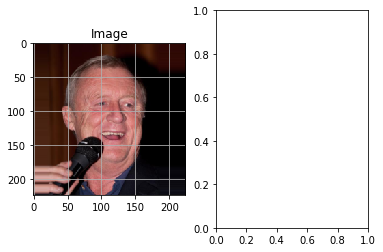

In [36]:
#Test our predictions
number = 1629
print(argmax(predictions[number]))
plotImage(testing_data[number])

## Save our results to CSV

In [ ]:
#Collect file names and predicted ages
file_names = []
ages = []
counter = 0
for file2 in os.listdir('test'):
    file_names.append(os.path.basename(file2))
    ages.append(argmax(predictions[counter]))
    counter= counter+1
    
#Sort the files in order    
ordered_files = sorted(file_names, key=lambda x: (int(re.sub('\D','',x)),x))

#Convert to pandas DF
files = pd.DataFrame(ordered_files)  
age = pd.DataFrame(ages) 

In [ ]:
#Concatenate the filenames and ages.
result = pd.concat([files, age],axis=1)
result.columns = ['Id', 'Expected']

In [ ]:
#Save to CSV
result.to_csv('answers_vgg_face_1.csv')